# EDA and some basic analyses

## EDA  
- regression
- scatter matrix
- dendrogram
- TSNE
- ecdf

## Basic analyses
The output figures are publishable and are saved to disk.  

- Analysis of strategical bidding with non-round prices  
  Hot plot of occurence of digits in winning prices. 
   
- Usage intensity  
  Above or below average usage (odometer reading) will determine car value. This is a quick analysis of usage intensity. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns

In [2]:
matplotlib.rcParams['font.sans-serif'] = ['Helvetica','Arial', 'sans-serif']
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 24
matplotlib.rcParams['ytick.labelsize'] = 24
matplotlib.rcParams['figure.titlesize'] = 24
matplotlib.rcParams['font.size'] = 18

In [3]:
def diff_month(d1, d2):
    
    '''returns difference in months between two datetime objects'''
    
    return (d1.year - d2.year) * 12 + d1.month - d2.month

def car_name(row):
    
    '''From dataframe row create a sensible name to identify car'''
    
    # index of row
    idx = row.name.strip()
    # fill NaN
    row.fillna({
        'inspection_age':-999.,
        'age':-999.,
    },inplace=True)
    # translate str to datatime object
    auct = pd.datetime.strptime(idx[0:-5],'%Y-%m')
    # Manufacture date and year
    mf = auct - pd.to_timedelta(row.age, unit='days')
    mfy = "'" + str(mf.year)[-2:]
    # Inspection date and diff in months
    apk = auct - pd.to_timedelta(row.days_since_inspection_invalid, unit='days')
    apk_month = diff_month(auct,apk)
    
    # construct name    
    name = '{} {:7} {} {} {} {:g}drs {:g}cc {:g}cyl {} {:.1f}km/day '.format(
        mfy,
        row.color,
        row.brand,
        row.model,
        row.body_type,
        row.number_of_doors,
        row.displacement,
        row.number_of_cylinders,
        row.fuel,
        row.odometer/row.age)
    
    # add inspection if any
    if row.days_since_inspection_invalid > 0:
        name += 'inspection invalid'
    else:
        name += 'inspection {:g}m'.format(-apk_month)
        
    return name


In [4]:
fn = '../data/cars-for-ml.pkl'
# fn = '../../../python-nb/data/cars-from-all-auctions-opbod.pkl'

print(fn)
df = pd.read_pickle(fn)
print(df.columns)

# categories
cat_columns = ['brand', 'model', 'fuel', 'body_type','color', 'energy_label', 'fwd']
print(list(df[cat_columns]))

# sensible name
df['car_name'] = df.apply(car_name,axis='columns')

print('last lot:',df.index[-1])

../data/cars-for-ml.pkl
Index(['price', 'brand', 'model', 'age', 'fuel', 'odometer',
       'days_since_inspection_invalid', 'age_at_import', 'body_type',
       'displacement', 'number_of_cylinders', 'power', 'weight',
       'registration_tax', 'sale_price', 'number_of_seats', 'number_of_doors',
       'color', 'fwd', 'top_speed', 'length', 'height', 'width',
       'number_of_gears', 'energy_label'],
      dtype='object')
['brand', 'model', 'fuel', 'body_type', 'color', 'energy_label', 'fwd']
last lot: 2019-11-8213


# Price

In [5]:
def get_nr_nc(n):
    nr = int(pd.np.ceil(n**(1/2)))
    nc = int(pd.np.ceil(n/nr))
    return nr,nc

['age' 'age_at_import' 'days_since_inspection_invalid' 'displacement'
 'height' 'length' 'number_of_cylinders' 'number_of_doors'
 'number_of_gears' 'number_of_seats' 'odometer' 'power' 'registration_tax'
 'sale_price' 'top_speed' 'weight' 'width']
age
age_at_import
days_since_inspection_invalid
displacement
height
length
number_of_cylinders
number_of_doors
number_of_gears
number_of_seats
odometer
power
registration_tax
sale_price
top_speed
weight
width


Text(0, 0.5, 'price [EUR]')

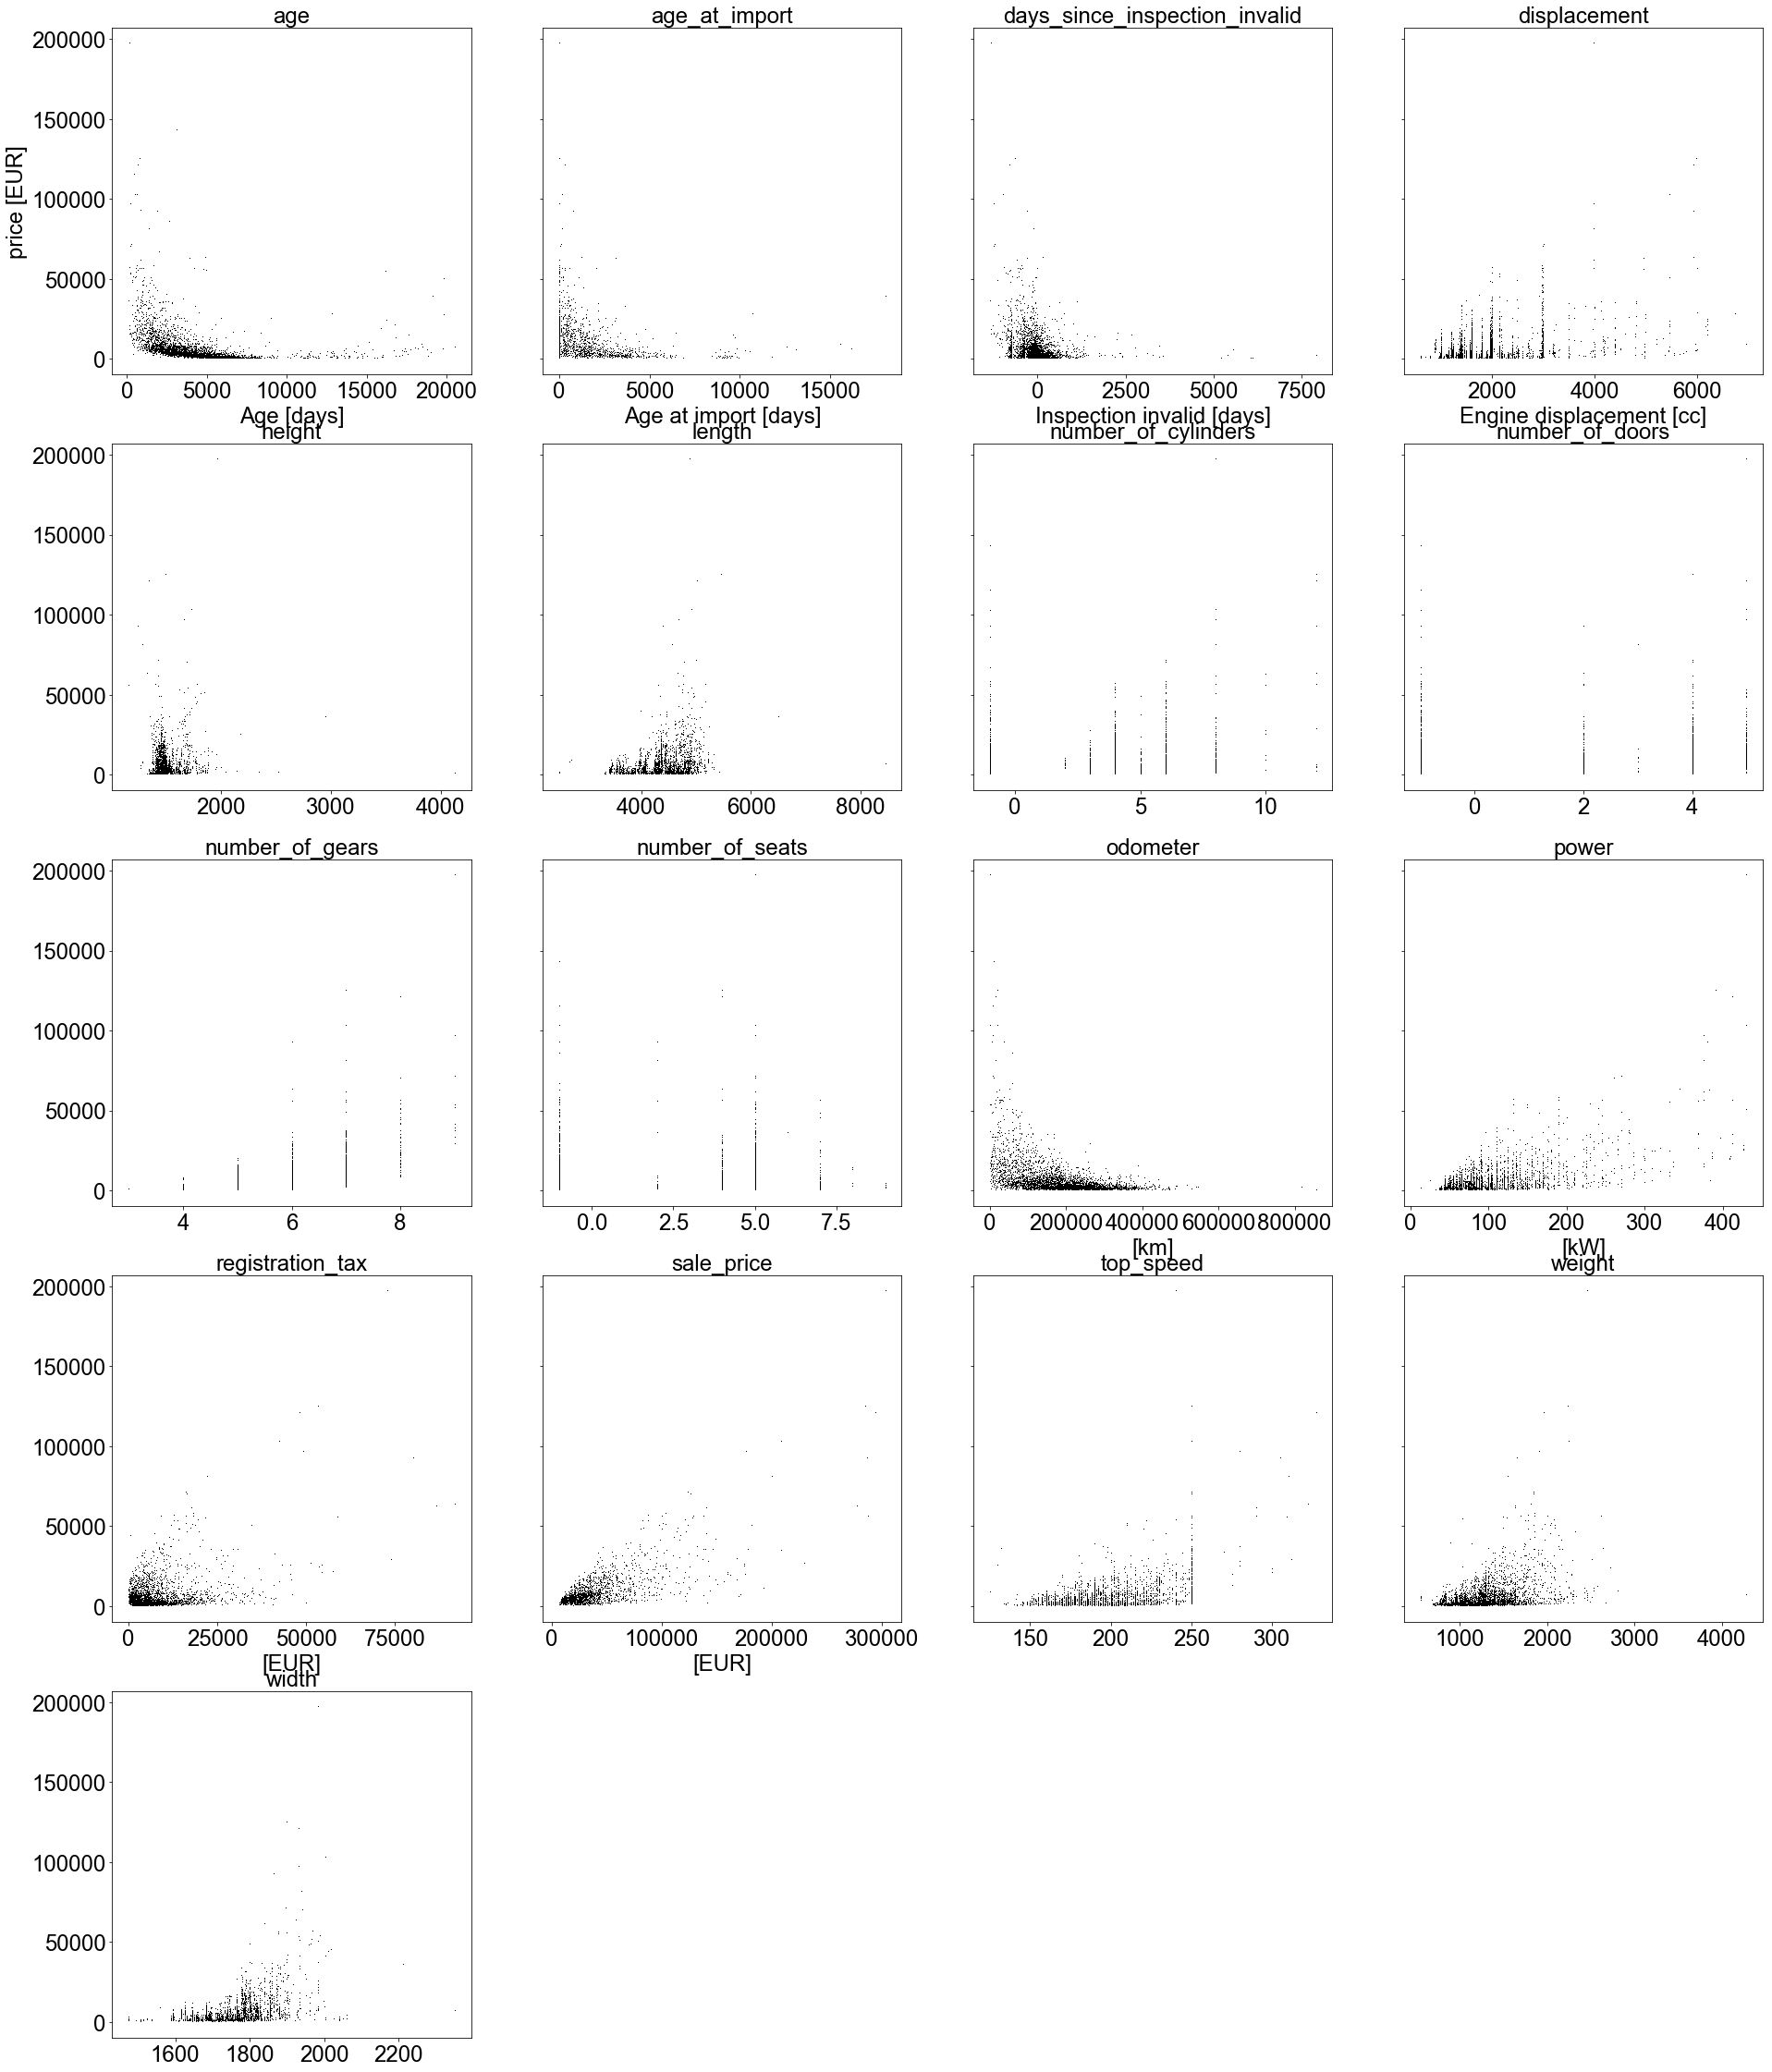

In [6]:
feat = pd.np.setdiff1d(df.columns, cat_columns + ['price', 'car_name'])
X = df.loc[:,feat]
y = df.price
print(feat)


nr,nc = get_nr_nc(len(feat))
fig,axs = plt.subplots(nrows=nr, ncols=nc, figsize=[8*nc,8*nr], sharey=True)

for iF,ax in enumerate(axs.ravel()):
    if iF >= len(feat):
        ax.set_visible(False)
        continue
        
    print(feat[iF])
    ax.plot(X.iloc[:,iF],y,',k')
    ax.set_title(feat[iF])
    if feat[iF] == 'displacement':
        ax.set_xlabel('Engine displacement [cc]')
    elif feat[iF] == 'age':
        ax.set_xlabel('Age [days]')
    elif feat[iF] == 'age_at_import':
        ax.set_xlabel('Age at import [days]')
    elif feat[iF] == 'days_since_inspection_invalid':
        ax.set_xlabel('Inspection invalid [days]')
    elif feat[iF] == 'power':
        #nettomaximumvermogen
        ax.set_xlabel('[kW]')
    elif feat[iF] == 'odometer':
        ax.set_xlabel('[km]')
    elif feat[iF] == 'registration_tax':
        ax.set_xlabel('[EUR]')
    elif feat[iF] == 'sale_price':
        ax.set_xlabel('[EUR]')

    
    
axs.ravel()[0].set_ylabel('price [EUR]')


In [7]:
yX = pd.concat([pd.DataFrame(y), X], axis='columns').fillna(pd.np.NaN)

# group per car brand
yX['brand'] = df.brand
grouped = yX.groupby('brand')
VW = grouped.get_group('VOLKSWAGEN')
RENAULT = grouped.get_group('RENAULT')
MERC = grouped.get_group('MERCEDES-BENZ')
FORD = grouped.get_group('FORD')
SMART = grouped.get_group('SMART')

Text(0.5, 0.98, 'Mercedes\nAll numerical features')

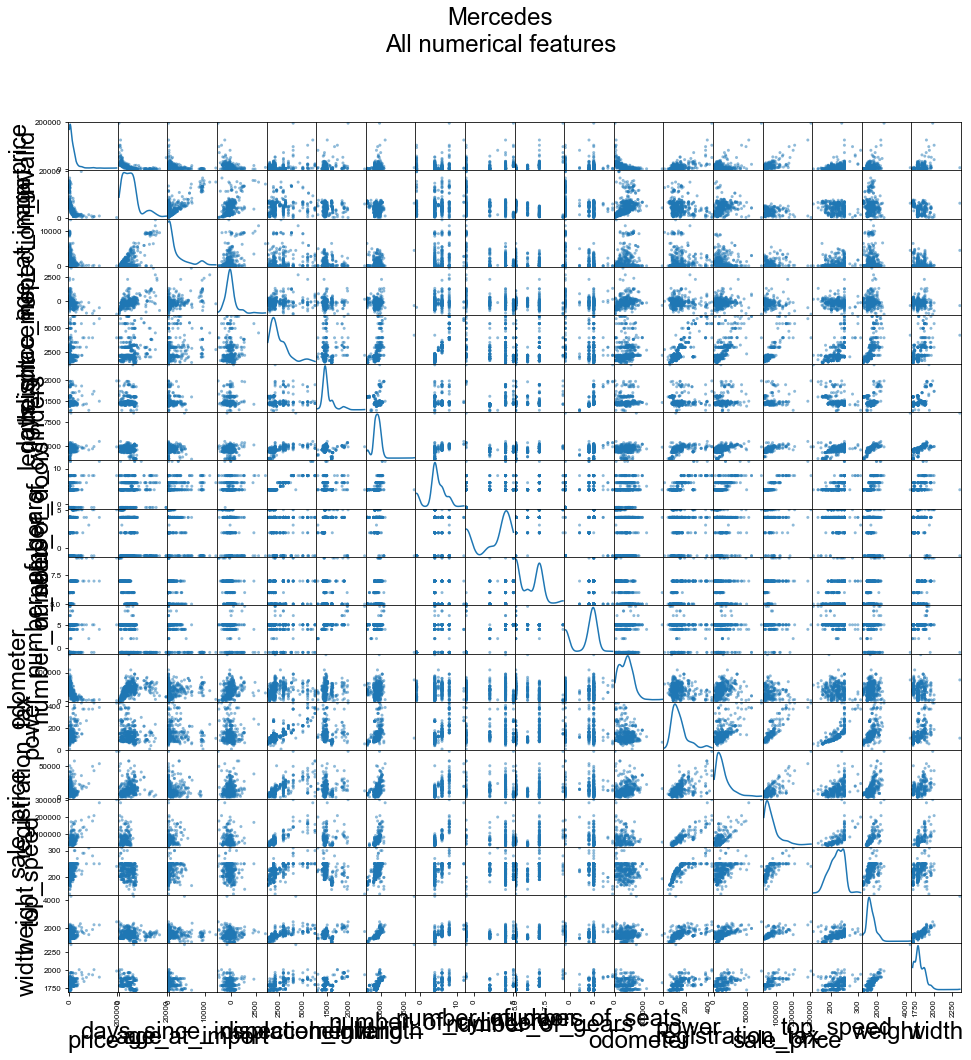

In [8]:
pd.plotting.scatter_matrix(MERC, grid=True, figsize=[16,16], diagonal='kde')
plt.suptitle('Mercedes\nAll numerical features')

# Distributions

In [9]:
def ecdf(data):
    d = data[data.notna()]
    y = pd.np.linspace(0,1,len(d))
    x = sorted(d)
    return x,y

## Simple bar graphs

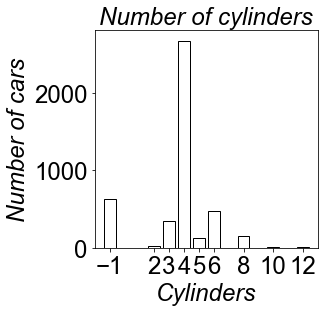

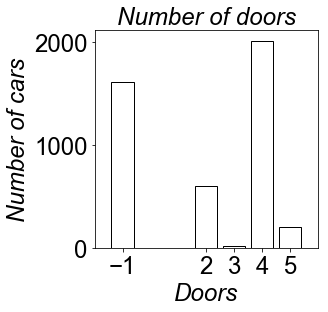

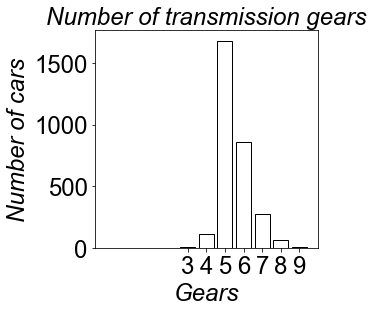

In [10]:
# loop over fields
for data, title_label, xaxis_label in zip(
    [
        yX.number_of_cylinders,
        yX.number_of_doors,
        yX.number_of_gears,
    ],
    [
        'Number of cylinders',
        'Number of doors',
        'Number of transmission gears',
    ],
    [
        'Cylinders',
        'Doors',
        'Gears'
    ]
):
    # "histogram"
    cnt = data.value_counts()
    # create figure
    plt.figure(figsize=[4,4])
    # plot bars
    plt.bar(x=cnt.index, height=cnt.values, edgecolor='k', facecolor='None')
    # prettify
    ax = plt.gca()
    ax.set_title(title_label, style='italic')
    ax.set_xlabel(xaxis_label, style='italic')
    ax.set_ylabel('Number of cars', style='italic')
    ax.set_xlim(left=-2, right=cnt.index.max()+1)
    ax.set_xticks(cnt.index)


## Ecdf of Length, Width, Height, Weight, Speed, Power etc.

Red is with imputed median

Length
	min: 2500.0
	mid: 4349.0
	max: 8450.0
	bin: 2000 : 200.0 : 9000 (n=35)
Width
	min: 1475.0
	mid: 1765.0
	max: 2350.0
	bin: 1000 : 25.0 : 2500 (n=60)
Height
	min: 1165.0
	mid: 1481.0
	max: 4128.0
	bin: 1000 : 50.0 : 5000 (n=80)
Weight
	min: 550.0
	mid: 1283.0
	max: 4280.0
	bin: 500 : 100.0 : 5000 (n=45)
Top speed
	min: 125.0
	mid: 191.0
	max: 327.0
	bin: 100 : 5.0 : 350 (n=50)
Power
	min: 13.0
	mid: 88.0
	max: 430.0
	bin: 0 : 10.0 : 500 (n=50)
Sale price
	min: 6914.0
	mid: 32457.0
	max: 303261.0
	bin: 0 : 10000.0 : 500000 (n=50)
Engine displacement
	min: 599.0
	mid: 1781.0
	max: 6965.0
	bin: 0 : 100.0 : 10000 (n=100)


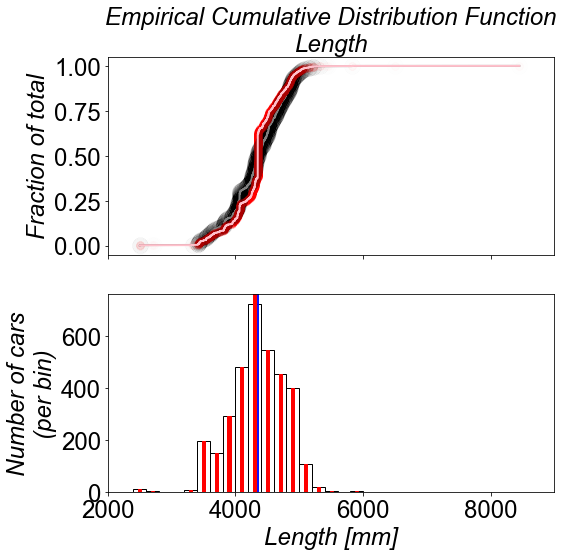

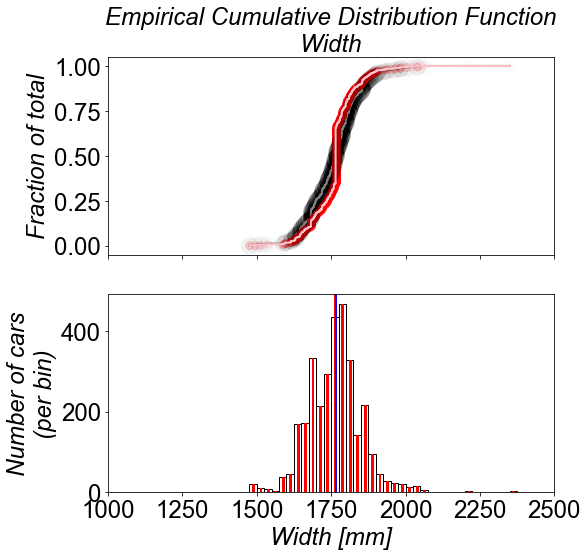

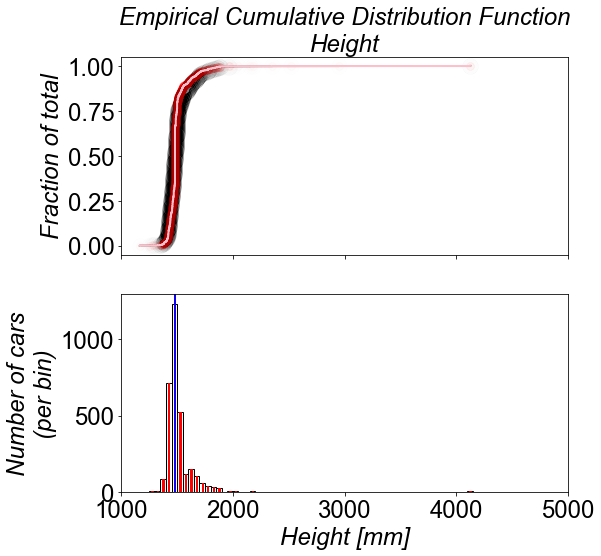

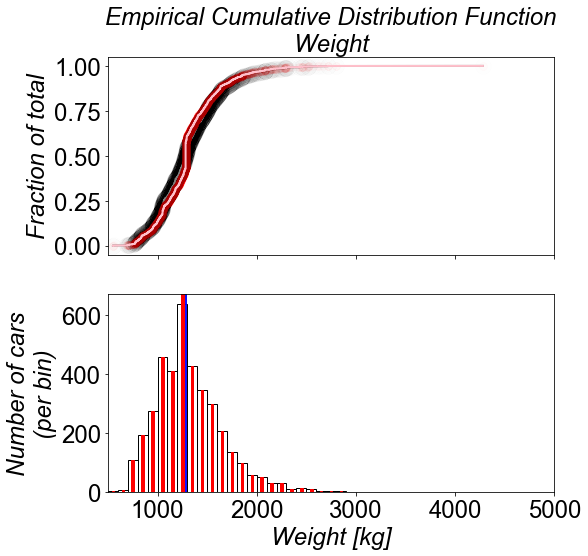

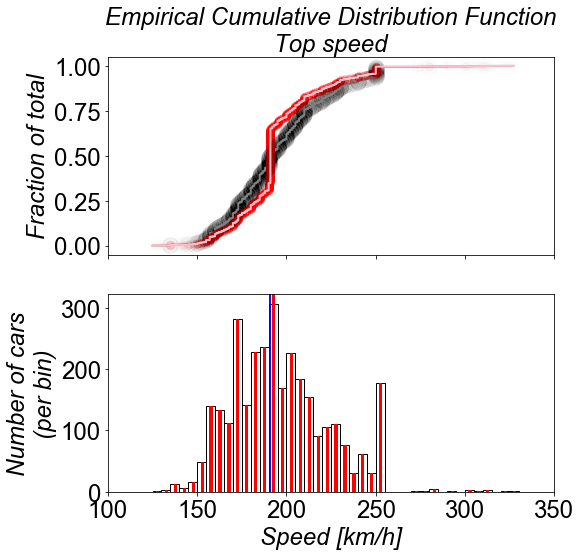

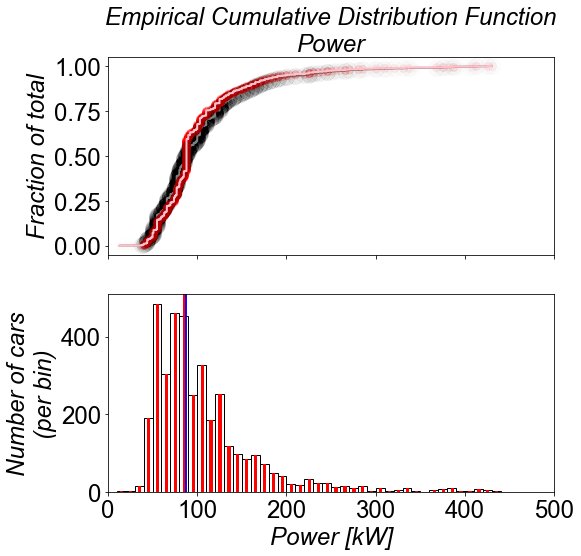

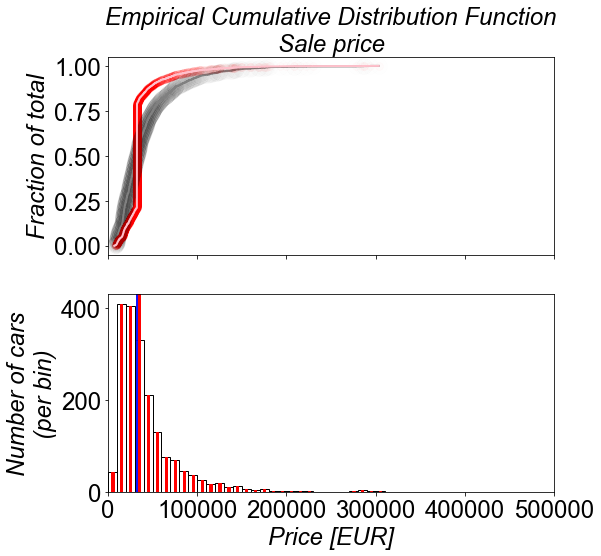

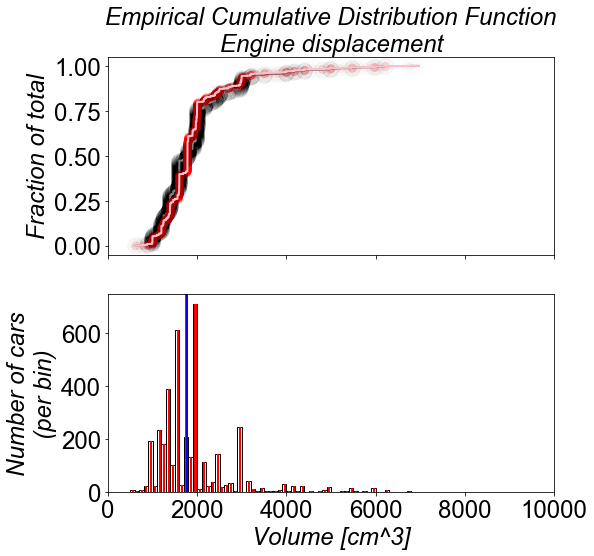

In [11]:
# loop over fields
for data, title_label, xaxis_label, bins in zip(
    # data
    [
        yX.length, 
        yX.width,
        yX.height,
        yX.weight,
        yX.top_speed,
        yX.power,
        yX.sale_price,
        yX.displacement,
    ],
    # title
    [
        'Length', 
        'Width',
        'Height',
        'Weight',
        'Top speed',
        'Power',
        'Sale price',
        'Engine displacement'
    ],
    # xlabel
    [
        'Length [mm]', 
        'Width [mm]',
        'Height [mm]',
        'Weight [kg]',
        'Speed [km/h]',
        'Power [kW]',
        'Price [EUR]',
        'Volume [cm^3]'
    ],
    # bins: left, right, nr of steps
    [
        (2000, 9000, 36), 
        (1000, 2500, 61),
        (1000, 5000, 81),
        (500, 5000, 46),
        (100, 350, 51), 
        (0, 500, 51), 
        (0, 500000, 51), 
        (0, 10000, 101)
    ],
):
    # separate tuple in 3 different values
    left_bin_edge, right_bin_edge, bin_steps = bins

    # prepare x and y from values
    x,y = ecdf(data)
    # store median value
    median_value = data.median()
    # reporting
    print('{}\n\tmin: {}\n\tmid: {}\n\tmax: {}\n\tbin: {} : {} : {} (n={})'.format(
        title_label, 
        x[0], median_value, x[-1], 
        left_bin_edge, (right_bin_edge-left_bin_edge)/(bin_steps-1), right_bin_edge, bin_steps-1
    ))
    # warn if out of bounds
    if (x[0] < left_bin_edge) or (x[-1] > right_bin_edge):
        print('>> CLIPPING <<\n')

    # plot full
    fig,axs=plt.subplots(figsize=[8,8], nrows=2, ncols=1, sharex=True)

    axs[0].step(x, y, color='k', marker='o', alpha=0.005, ms=16)
    axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)

    axs[1].hist(x, bins=pd.np.linspace(left_bin_edge, right_bin_edge, bin_steps), edgecolor='k', facecolor='None')
    yl=axs[1].get_ylim()
    axs[1].vlines(x=median_value, ymin=0, ymax=yl[1], color='b')
    axs[1].set_ylim(bottom=yl[0], top=yl[1])


    # prepare data with median replacing NaNs
    data = data.fillna(median_value)
    x,y = ecdf(data)

    # plot nan replaced
    axs[0].step(x, y, color='r', marker='o', alpha=0.01, ms=8)
    axs[0].step(x, y, color='pink', linestyle='-', linewidth=2)

    axs[1].hist(x, bins=pd.np.linspace(left_bin_edge, right_bin_edge, bin_steps), edgecolor='r', facecolor='r', rwidth = 0.25)
    yl=axs[1].get_ylim()
    axs[1].vlines(x=median_value, ymin=0, ymax=yl[1], color='b')
    axs[1].set_ylim(bottom=yl[0], top=yl[1])
    
    # prettify
    axs[0].set_xlim(left=left_bin_edge, right=right_bin_edge)
    axs[0].set_title('Empirical Cumulative Distribution Function\n' + title_label, style='italic')
    axs[0].set_yticks(pd.np.linspace(0,1.0,5))
    axs[1].set_xlabel(xaxis_label, style='italic')
    axs[0].set_ylabel('Fraction of total', style='italic')
    axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')


## Age at import
zoom into two clusters of data

Text(0.5, 1.0, 'old')

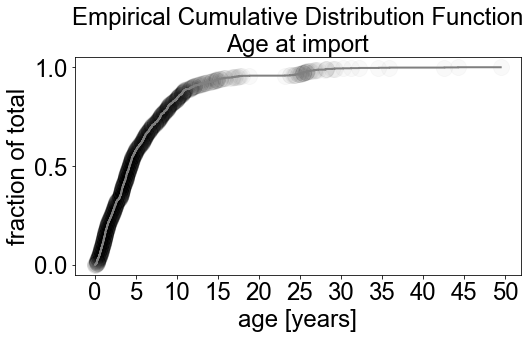

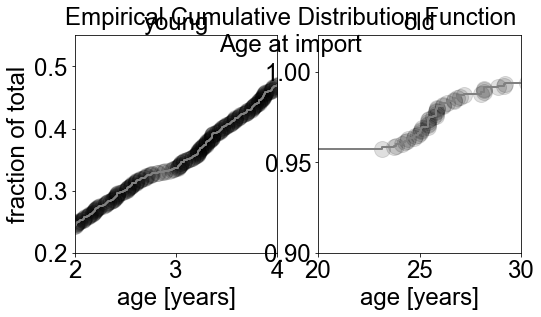

In [12]:
data = yX.age_at_import[yX.age_at_import>0]/365.25
x,y = ecdf(data)

# plot full
plt.figure(figsize=[8,4])
plt.step(x, y, color='k', marker='o', alpha=0.025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.title('Empirical Cumulative Distribution Function\nAge at import')
plt.xlabel('age [years]')
plt.ylabel('fraction of total')
plt.xticks(range(0,55,5))


# plot old/young
fig,axs = plt.subplots(figsize=[8,4], ncols=2, nrows=1)
axs[0].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[1].step(x, y, color='grey', linestyle='-', linewidth=2)
fig.suptitle('Empirical Cumulative Distribution Function\nAge at import')
axs[0].set_xlim(left=2, right=4)
axs[1].set_xlim(left=20, right=30)
axs[0].set_ylim(bottom=0.2, top=0.55)
axs[1].set_ylim(bottom=0.9, top=1.02)
axs[0].set_ylabel('fraction of total')
axs[0].set_xlabel('age [years]')
axs[1].set_xlabel('age [years]')
axs[0].set_title('young')
axs[1].set_title('old')


## Price
on log scale

Text(0, 0.5, 'Number of cars\n(per bin)')

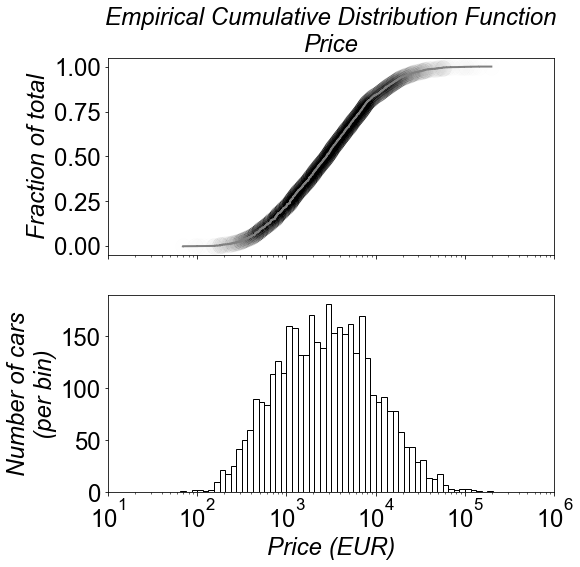

In [13]:
data = df.price
x,y = ecdf(data)

# plot full
fig,axs=plt.subplots(figsize=[8,8], nrows=2, ncols=1, sharex=True)

axs[0].step(x, y, color='k', marker='o', alpha=0.005, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
# axs[0].plot(median_usage, 0.5, marker='+', color='b', ms=64)
# axs[0].text(median_usage,0.5,'Median: {:.1f} km/day      '.format(median_usage), ha='right', va='center', color='b', weight='bold')

axs[1].hist(x, bins=pd.np.logspace(1,6,81), edgecolor='k', facecolor='None')
yl=axs[1].get_ylim()
# axs[1].vlines(x=median_usage, ymin=0, ymax=yl[1], color='b')

axs[0].set_xscale('log')
axs[0].set_xlim(left=10, right=1000000)
axs[0].set_title('Empirical Cumulative Distribution Function\nPrice', style='italic')
axs[0].set_yticks(pd.np.linspace(0,1.0,5))
axs[1].set_xlabel('Price (EUR)', style='italic')
axs[0].set_ylabel('Fraction of total', style='italic')
axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')


- - - - 
# Dendrogram

This is a form of classification and produce a tree-like visualization


cluster 1

	'07 GRIJS   VOLKSWAGEN passat stationwagen 4drs 1968cc 4cyl diesel 118.7km/day inspection invalid
	'11 BLAUW   VOLKSWAGEN polo hatchback -1drs 1598cc 4cyl diesel 124.5km/day inspection invalid
	'09 GRIJS   VOLKSWAGEN passat cc sedan 4drs 1968cc 4cyl diesel 105.7km/day inspection invalid

cluster 2

	'11 ZWART   VOLKSWAGEN golf stationwagen -1drs 1197cc 4cyl benzine 108.0km/day inspection 6m
	'12 ZWART   VOLKSWAGEN polo hatchback 5drs 1199cc 3cyl diesel 156.6km/day inspection 5m
	'10 ZWART   VOLKSWAGEN golf stationwagen 4drs 1598cc 4cyl diesel 93.0km/day inspection 6m
	'10 GRIJS   VOLKSWAGEN polo hatchback -1drs 1598cc 4cyl diesel 97.6km/day inspection 6m
	'10 ZWART   VOLKSWAGEN polo hatchback -1drs 1598cc 4cyl diesel 83.7km/day inspection 12m
	'09 GRIJS   VOLKSWAGEN polo hatchback 4drs 1598cc 4cyl diesel 102.9km/day inspection 13m
	'08 ZWART   VOLKSWAGEN golf stationwagen -1drs 1968cc 4cyl diesel 68.4km/day inspection 13m
	'11 WIT     VOLKSWAGEN polo hatchback -1drs 1598cc

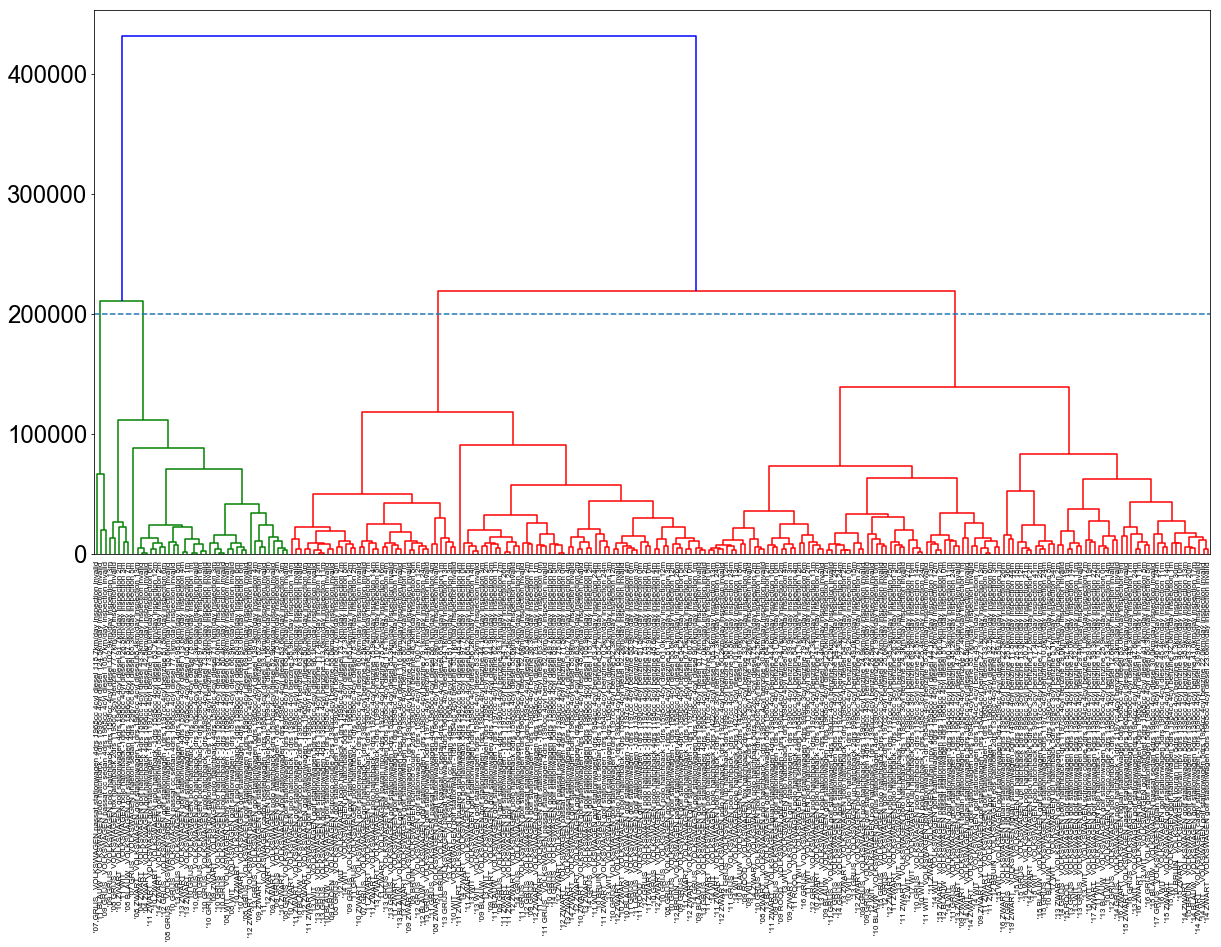

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

pd.np.random.seed(42)

train = VW.drop(columns='brand').dropna()

mergings = linkage(train,method='complete')
brand_names = df.loc[train.index,'brand']
model_names = df.loc[train.index,'model']
color_names = df.loc[train.index,'color']
fuel_names = df.loc[train.index,'fuel']
lot_names = df.loc[train.index,:].index
names = df.loc[train.index,"car_name"]
# names = brand_names
plt.figure(figsize=[20,10])
dendrogram(mergings,
           labels=names,
           leaf_rotation=90,
           leaf_font_size=8,
          );

level = 200000 # arbitrary!
plt.plot([0,train.shape[0]*10],[level,level],'--')
labels = fcluster(mergings,level,criterion='distance')

for l in range(1,labels.max()+1):
    print('\ncluster {}\n'.format(l))
    idx = train[labels == l].index
    for i in idx:
        print('\t{}'.format(df.loc[i,"car_name"]))
    

# tSNE

see if there are clusters

#### Train

In [15]:
from sklearn.manifold import TSNE

# remove categories
train = df.drop(columns=['brand','model','fuel','body_type','color','car_name', 'energy_label', 'fwd']).dropna()
display(train.info())
display(train.describe())

model = TSNE(learning_rate = 100,verbose=1)
transformed = model.fit_transform(train)


<class 'pandas.core.frame.DataFrame'>
Index: 1137 entries, 2017-3-2202 to 2019-11-8207
Data columns (total 18 columns):
price                            1137 non-null float64
age                              1137 non-null float64
odometer                         1137 non-null float64
days_since_inspection_invalid    1137 non-null float64
age_at_import                    1137 non-null float64
displacement                     1137 non-null float64
number_of_cylinders              1137 non-null object
power                            1137 non-null float64
weight                           1137 non-null float64
registration_tax                 1137 non-null float64
sale_price                       1137 non-null float64
number_of_seats                  1137 non-null int64
number_of_doors                  1137 non-null int64
top_speed                        1137 non-null float64
length                           1137 non-null float64
height                           1137 non-null float64
width

None

,price,age,odometer,days_since_inspection_invalid,age_at_import,displacement,power,weight,registration_tax,sale_price,number_of_seats,number_of_doors,top_speed,length,height,width,number_of_gears
count,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000,1137.000000
mean,10018.623571,2601.974494,143600.095937,-181.709763,462.357960,1810.548813,108.006245,1310.789798,6074.138083,41215.274406,4.921724,3.356201,200.370273,4370.245383,1507.152155,1778.658751,5.903254
std,12589.447662,1214.293176,91208.509755,393.825422,812.477961,745.444081,60.777613,285.723499,6868.482960,32658.685643,0.610957,1.681177,27.993100,389.313635,96.633294,77.079114,0.927551
min,182.000000,107.000000,919.000000,-1354.000000,0.000000,796.000000,38.000000,750.000000,58.000000,6914.000000,2.000000,-1.000000,141.000000,2695.000000,1250.000000,1495.000000,4.000000
25%,3530.000000,1668.000000,73029.000000,-393.000000,0.000000,1390.000000,70.000000,1108.000000,2029.000000,22140.000000,5.000000,4.000000,180.000000,4070.000000,1455.000000,1737.000000,5.000000
50%,6611.000000,2550.000000,137478.000000,-157.000000,0.000000,1598.000000,90.000000,1285.000000,4573.000000,32200.000000,5.000000,4.000000,195.000000,4360.000000,1488.000000,1785.000000,6.000000
75%,12611.000000,3477.000000,198436.000000,11.000000,640.000000,1991.000000,125.000000,1475.000000,7487.000000,47475.000000,5.000000,4.000000,218.000000,4666.000000,1510.000000,1820.000000,6.000000
max,197000.000000,5455.000000,816757.000000,2318.000000,4544.000000,6209.000000,430.000000,2671.000000,80168.000000,303261.000000,9.000000,5.000000,327.000000,5457.000000,2524.000000,2050.000000,9.000000


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1137 samples in 0.006s...
[t-SNE] Computed neighbors for 1137 samples in 0.045s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1137
[t-SNE] Computed conditional probabilities for sample 1137 / 1137
[t-SNE] Mean sigma: 2018.578770
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.851231
[t-SNE] KL divergence after 1000 iterations: 0.439812


#### plot

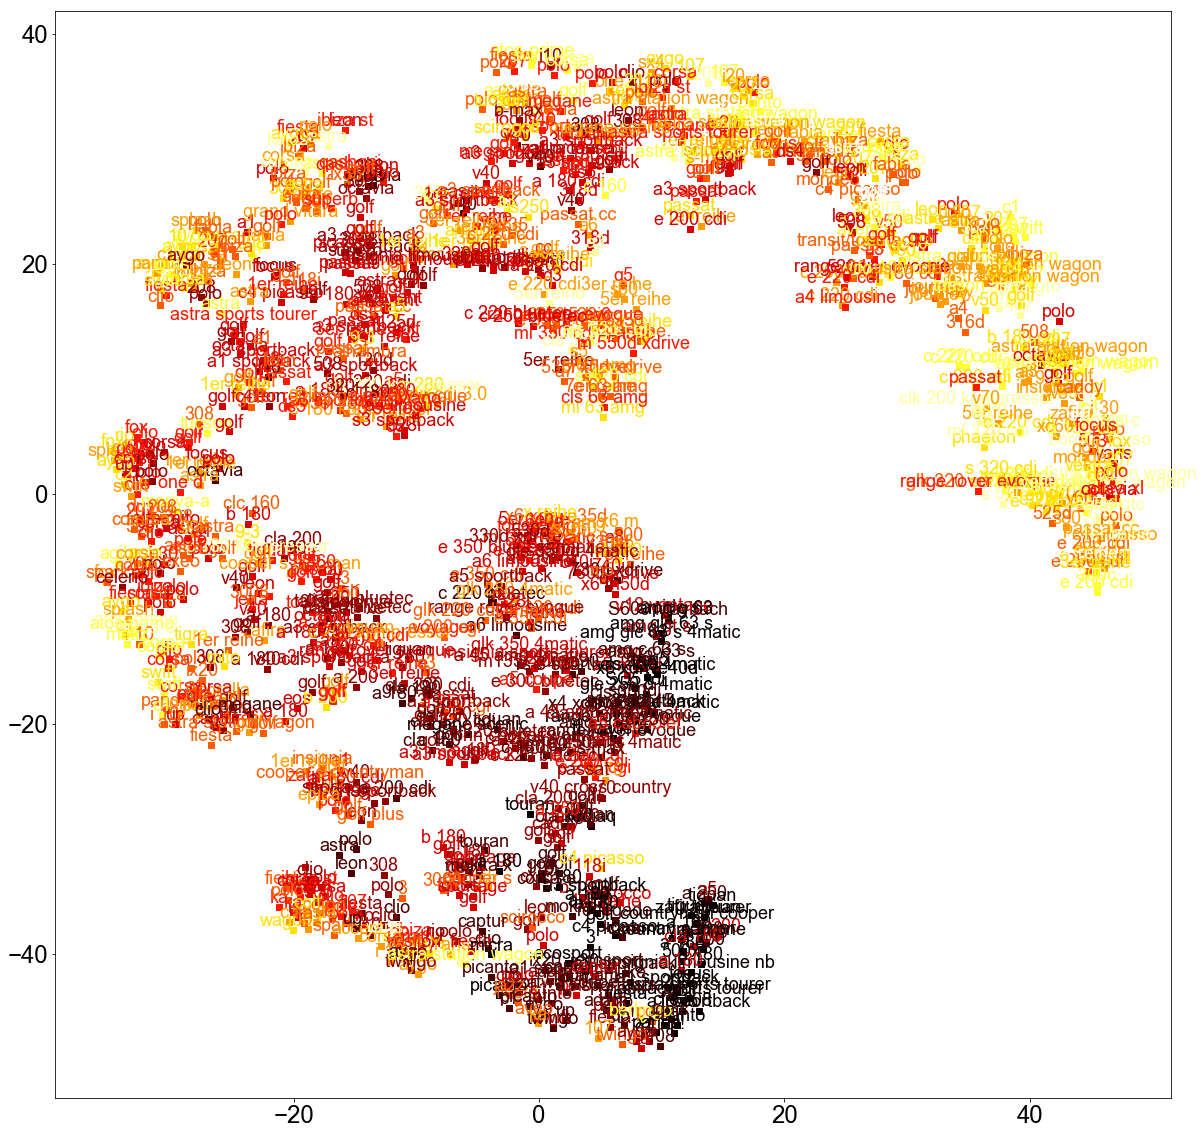

In [16]:
# Labeling

# year
year_bins = pd.np.arange(
    df.loc[train.index,"age"].min(),
    df.loc[train.index,"age"].max(),365)
year_labels = [i for i in range(len(year_bins)-1)]

# price
price_bins = pd.np.arange(
    df.loc[train.index,"price"].min(),
    df.loc[train.index,"price"].max(),500)
price_labels = [i for i in range(len(price_bins)-1)]

# color, fuel, brand
labels = df.loc[train.index,'color']
labels = df.loc[train.index,'fuel']
labels = df.loc[train.index,'brand']
labels = pd.factorize(labels)[0]

labels = pd.cut(train.age,bins=year_bins,labels=year_labels)
labels = pd.cut(train.age,bins=price_bins,labels=price_labels)

# name labels
names = df.loc[train.index,'model']

# plot
xs = transformed[:,0]
ys = transformed[:,1]
plt.figure(figsize=[20,20])
plt.set_cmap('hot')
plt.scatter(xs,ys,c=labels,marker='s')
cm=plt.get_cmap()
# text labels
for x,y,t,l in zip(xs,ys,names,labels):
    c = cm(l/max(labels))
    plt.text(x,y,t,color=c,ha='center',va='bottom')


- - - - 
# Results

The results here below surpass eda and are beter made suitable for publication
- - - - 

# Last digits of price

In [17]:
# 2d hist
last0_digit = df.price.dropna().astype(str).apply(lambda x:x[-3]).astype(int)
last1_digit = df.price.dropna().astype(str).apply(lambda x:x[-4]).astype(int)
cnt,b0,b1 = pd.np.histogram2d(last1_digit, last0_digit, bins=[10,10],range=[(-0.5,9.5),(-0.5,9.5)])
_xx, _yy = pd.np.meshgrid(b0[1:]-.5, b1[1:]-.5)
x, y = _xx.ravel(), _yy.ravel()

# normalize to expected value if homogenous
norm_cnt = pd.np.log10(cnt/(cnt.ravel().sum()/100))

# sort reversed
idx = cnt.ravel().argsort()[::-1]

digits = pd.DataFrame(data={
    'occurrence':cnt.ravel().astype(int),
    'normalized':norm_cnt.ravel()[idx],
    'last-1':y.astype(int),
    'last-0':x.astype(int),
    'last 2 digits':['{:02.0f}'.format(f) for f in (y*10 + x)]
}).set_index('last 2 digits')
digits.sort_values(by='occurrence', ascending=False, inplace=True)
digits

,occurrence,normalized,last-1,last-0
last 2 digits,,,,
00,354,0.965804,0,0
50,149,-0.136041,5,0
55,137,-0.185259,5,5
11,127,0.261899,1,1
01,86,0.589987,0,1
77,85,-0.469255,7,7
89,84,-0.738101,8,9
60,81,-0.240776,6,0
78,80,-0.504018,7,8


In [18]:
digits_max = digits.iloc[0,[c in ['last-1','last-0'] for c in digits.columns]]
digits_min = digits.iloc[-1,[c in ['last-1','last-0'] for c in digits.columns]]

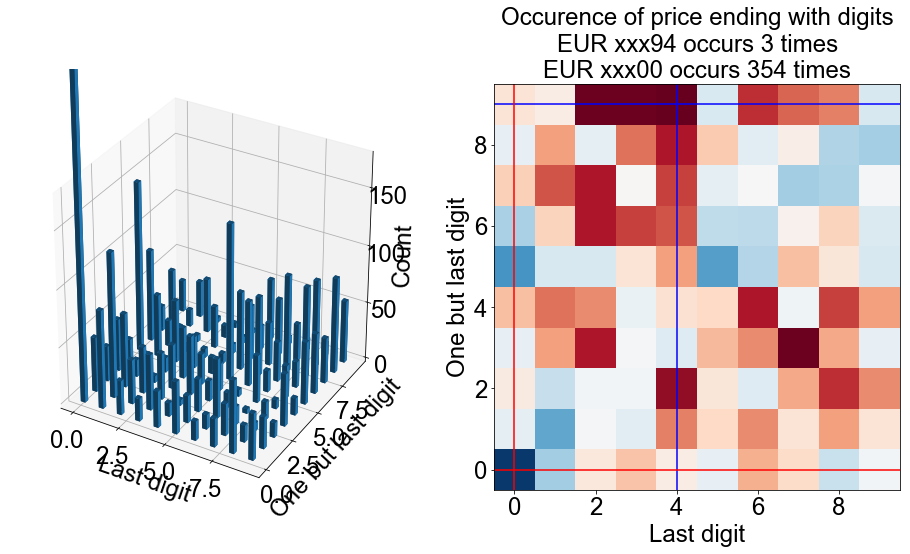

In [19]:
# plot
from mpl_toolkits.mplot3d import Axes3D

width = depth = .25
bottom = pd.np.zeros_like(cnt.ravel())

fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax1.bar3d(x,y,bottom,width,depth,cnt.ravel())

ax2 = fig.add_subplot(122)
ax2.imshow(norm_cnt,vmax=+1,vmin=-1,
           cmap='RdBu',
           origin='lower')

plt.hlines(digits_min[0],-0.5,9.5,color='b')
plt.vlines(digits_min[1],-0.5,9.5,color='b')
plt.hlines(digits_max[0],-0.5,9.5,color='r')
plt.vlines(digits_max[1],-0.5,9.5,color='r')

ax1.set_xlabel('Last digit')
ax2.set_xlabel('Last digit')
ax1.set_ylabel('One but last digit')
ax2.set_ylabel('One but last digit')
ax1.set_zlabel('Count')
ax1.set_zlim(top=cnt.max()/2)
ax2.set_title('Occurence of price ending with digits\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times\nEUR xxx{:1.0f}{:1.0f} occurs {:.0f} times'.format(*digits_min,digits.iloc[-1].occurrence,
                                                                                                  *digits_max,digits.iloc[0].occurrence));


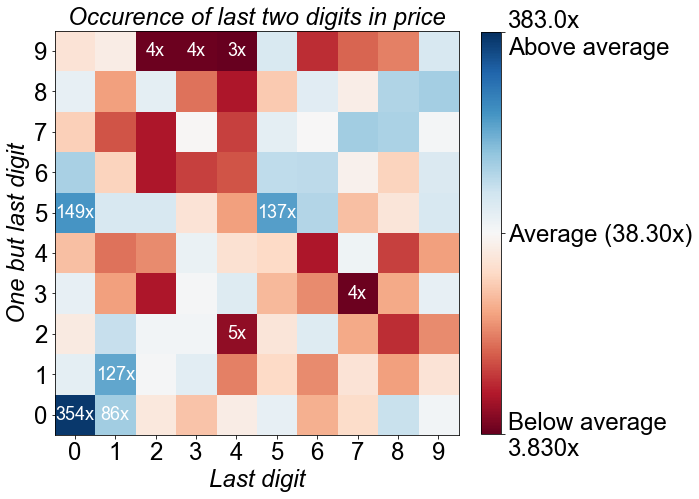

In [20]:
# plot for publication
fig,ax = plt.subplots(figsize=(8, 8))
imgplot = ax.imshow(norm_cnt,vmax=1,vmin=-1,
           cmap='RdBu',
           origin='lower')

# least and most occuring pairs
for i,d in digits.iloc[0:5,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label,
            color='w',
            ha='center',va='center',
            bbox={'alpha':0,'color':'k'})
for i,d in digits.iloc[-5:,:].iterrows():
    x=d['last-0']
    y=d['last-1']
    label = '{:g}x'.format(d.occurrence)
    ax.text(x,y,label, 
            color='w',
            ha='center',va='center',
            bbox={'alpha':0,'color':'k'})
    
# labels
ax.set_xticks(range(0,10))
ax.set_yticks(range(0,10))
ax.set_title('Occurence of last two digits in price', style='italic')
ax.set_xlabel('Last digit', style='italic')
ax.set_ylabel('One but last digit', style='italic')

# colorbar
cbar = fig.colorbar(imgplot, ticks=[-1,0,+1], fraction=.045, aspect=20)
cbar.ax.set_yticklabels([
    'Below average\n{:.3f}x'.format(cnt.ravel().sum()/1000), 
    'Average ({:.2f}x)'.format(cnt.ravel().sum()/100), 
    '{:.1f}x\nAbove average'.format(cnt.ravel().sum()/10), 
])

# save
plt.savefig('../results/last-two-digits.png', bbox_inches='tight', transparent=True)

# Usage intensity

Distance travelled

## Odometer

median odo meter: 183.824


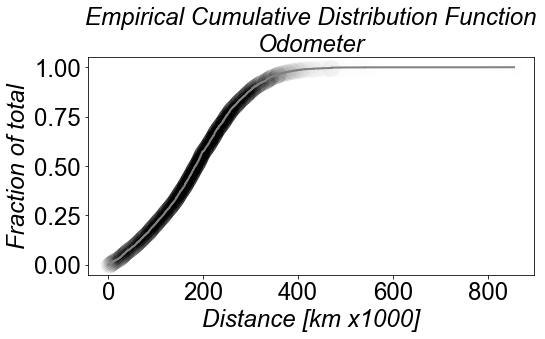

In [21]:
data = yX.odometer/1000
x,y = ecdf(data)

# plot full
plt.figure(figsize=[8,4])
plt.step(x, y, color='k', marker='o', alpha=0.0025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.title('Empirical Cumulative Distribution Function\nOdometer', style='italic')
plt.xlabel('Distance [km x1000]', style='italic')
plt.ylabel('Fraction of total', style='italic')

plt.yticks(pd.np.linspace(0,1.0,5))

print('median odo meter:', pd.np.median(x))

plt.savefig('../results/odometer-ecdf.png', bbox_inches='tight', transparent=False)

## Car age

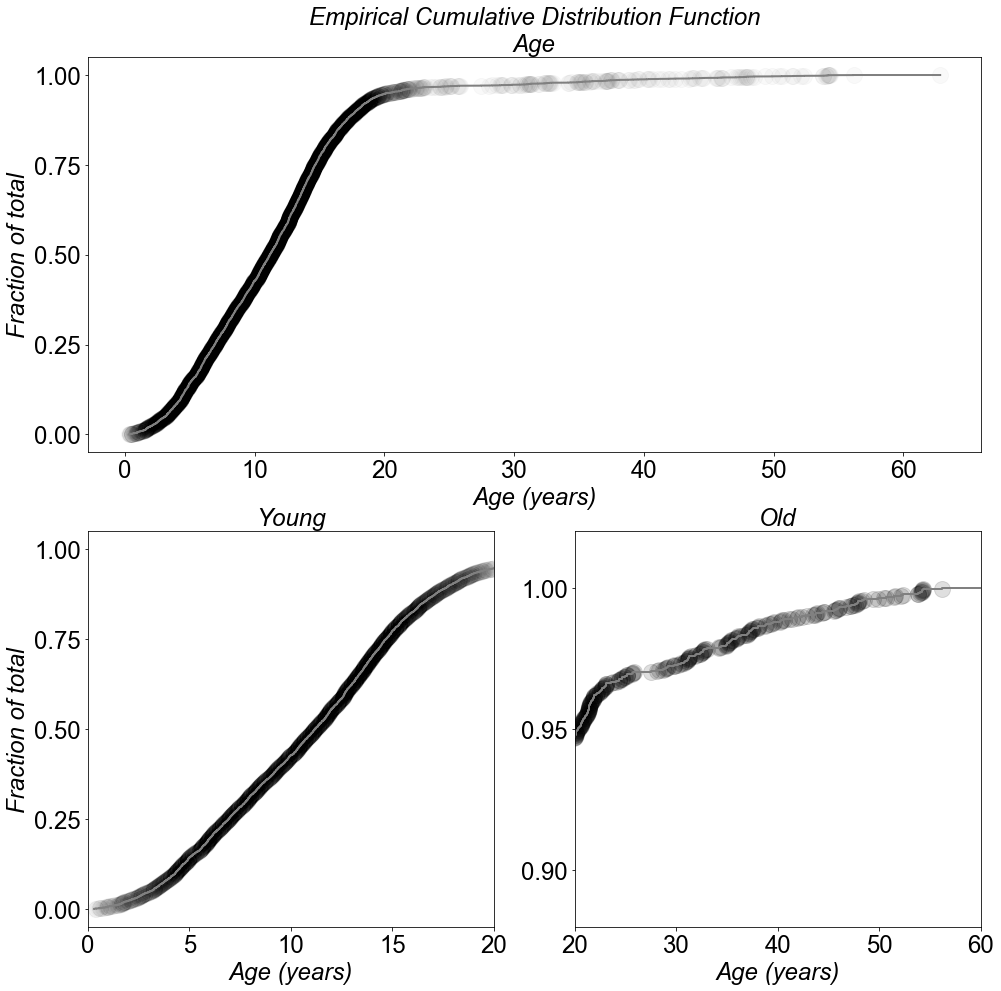

In [22]:
data = yX.age[yX.age>0]/365.25
x,y = ecdf(data)


fig,axs = plt.subplots(figsize=[16,16], ncols=2, nrows=2)
# plot full
plt.subplot(211)
plt.step(x, y, color='k', marker='o', alpha=0.025, ms=16)
plt.step(x, y, color='grey', linestyle='-', linewidth=2)
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Fraction of total', style='italic')
plt.title('Empirical Cumulative Distribution Function\nAge', style='italic')
plt.yticks(pd.np.linspace(0,1.0,5))
plt.gca().tick_params(labelsize=24)

# plot old/young
axs[1][0].step(x, y, color='k', marker='o', alpha=0.01, ms=16)
axs[1][0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][1].step(x, y, color='k', marker='o', alpha=0.125, ms=16)
axs[1][1].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[1][0].set_yticks(pd.np.linspace(0,1.0,5))
axs[1][1].set_yticks(pd.np.linspace(0,1.0,21))
axs[1][0].set_xlim(left=0, right=20)
axs[1][1].set_xlim(left=20, right=60)
axs[1][1].set_ylim(bottom=0.88, top=1.02)
axs[1][0].set_ylabel('Fraction of total', style='italic')
axs[1][0].set_xlabel('Age (years)', style='italic')
axs[1][1].set_xlabel('Age (years)', style='italic')
axs[1][0].set_title('Young', style='italic')
axs[1][1].set_title('Old', style='italic')


plt.savefig('../results/age-ecdf.png', bbox_inches='tight', transparent=True)

## Usage

In [23]:
is_diesel = df.fuel == 'diesel' # for future usage
usage = df.odometer/df.age
median_usage = usage.median()

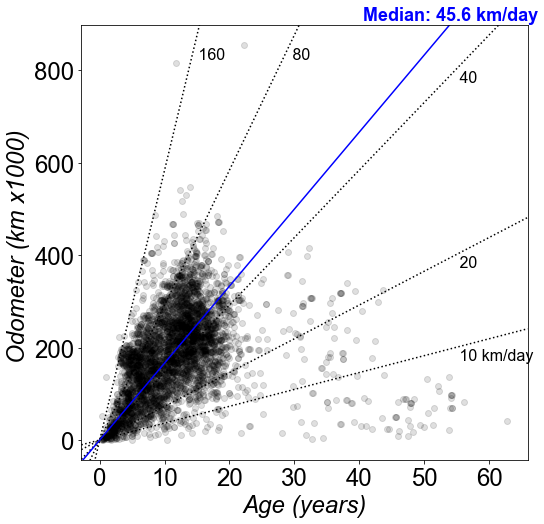

In [24]:
plt.figure(figsize=[8,8])
plt.plot(df.age/365.25,df.odometer/1000, 'k', linestyle='None', marker='o', alpha=0.125)
plt.xlabel('Age (years)', style='italic')
plt.ylabel('Odometer (km x1000) ', style='italic')
xl = plt.xlim()
yl = plt.ylim()
xx = pd.np.array(xl)*365.25
for p_d in [10, 20,40,80, 160]:
    yy = xx * p_d
    plt.plot(xx/365.25,yy/1000,':k')

    if p_d < 50:
        x = 20000
        y = p_d*x    
    else:
        y = 850000
        x = y/p_d
    if p_d == 10:
        txt_pat = ' {} km/day'
    else:
        txt_pat = ' {}'
    plt.text(x/365.25, y/1000, txt_pat.format(p_d), va='top', fontsize=16)

p_d = median_usage
yy = xx * p_d
plt.plot(xx/365.25,yy/1000,'-b')
plt.text(900000/median_usage/365.25,900000/1000,'Median: {:.1f} km/day'.format(median_usage), ha='center', va='bottom', color='b', fontweight='bold')
plt.xlim(xl)
plt.ylim(yl)
plt.xticks(range(0,65,10))

plt.savefig('../results/usage-regression.png', bbox_inches='tight', transparent=True)

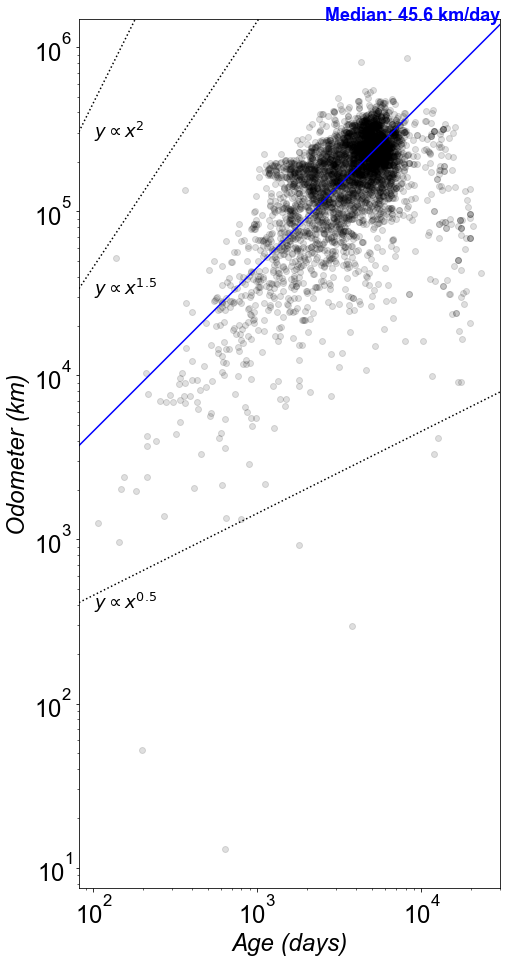

In [25]:
plt.figure(figsize=[16,16])
plt.plot(df.age,df.odometer, 'k', linestyle='None', marker='o', alpha=0.125)
plt.xlabel('Age (days)', style='italic')
plt.ylabel('Odometer (km)', style='italic')
plt.xscale('log')
plt.yscale('log')
plt.gca().set_aspect('equal')

xl = plt.xlim()
yl = plt.ylim()
p_d = median_usage
xx = pd.np.array(xl)
yy = xx * p_d
plt.plot(xx,yy,'-b')
plt.text(xx[1],xx[1] * p_d,'Median: {:.1f} km/day'.format(median_usage), ha='right', va='bottom', color='b', fontweight='bold')
for angle,offset in zip([0.5, 1, 1.5, 2], [1,1,1,1]):
    if angle == 1:
        continue
    yy = xx ** angle * median_usage * offset
    plt.plot(xx,yy,':',color='k')
    plt.text(xx[0],xx[0] ** angle * median_usage * offset,'   $y \propto x^{{{:g}}}$  '.format(angle,median_usage), ha='left', va='center', color='k')


plt.xlim(xl)
plt.ylim(yl)

plt.savefig('../results/usage-regression-loglog.png', bbox_inches='tight', transparent=True)

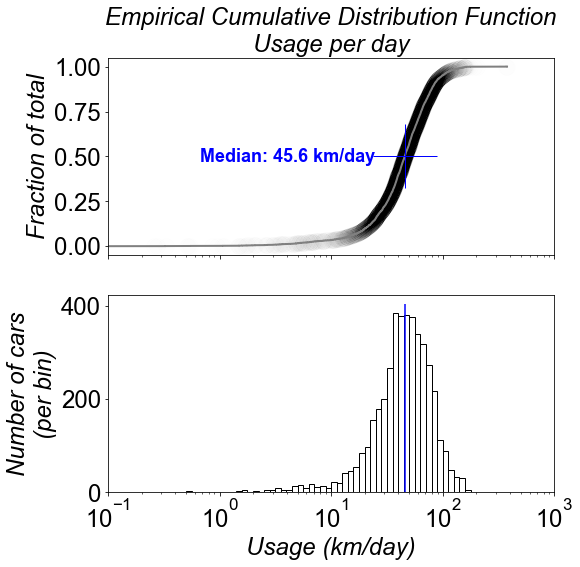

In [26]:
data = usage
x,y = ecdf(data)

# plot full
fig,axs=plt.subplots(figsize=[8,8], nrows=2, ncols=1, sharex=True)

axs[0].step(x, y, color='k', marker='o', alpha=0.005, ms=16)
axs[0].step(x, y, color='grey', linestyle='-', linewidth=2)
axs[0].plot(median_usage, 0.5, marker='+', color='b', ms=64)
axs[0].text(median_usage,0.5,'Median: {:.1f} km/day      '.format(median_usage), ha='right', va='center', color='b', weight='bold')

axs[1].hist(x, bins=pd.np.logspace(-1,3,81), edgecolor='k', facecolor='None')
yl=axs[1].get_ylim()
axs[1].vlines(x=median_usage, ymin=0, ymax=yl[1], color='b')

axs[0].set_xscale('log')
axs[0].set_xlim(left=0.1, right=1000)
axs[0].set_title('Empirical Cumulative Distribution Function\nUsage per day', style='italic')
axs[0].set_yticks(pd.np.linspace(0,1.0,5))
axs[1].set_xlabel('Usage (km/day)', style='italic')
axs[0].set_ylabel('Fraction of total', style='italic')
axs[1].set_ylabel('Number of cars\n(per bin)', style='italic')

plt.savefig('../results/usage-dist.png', bbox_inches='tight', transparent=False)